**A note for learning [statmorph](https://statmorph.readthedocs.io/en/latest/)**  
@Author: Ray  
@Update date: 2022-11-14

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from astropy.visualization import simple_norm
from astropy.modeling import models
from astropy.convolution import convolve
import photutils
import time
import statmorph

## 创建模拟的星系图像

使用Sérsic profile生成星系模拟图像

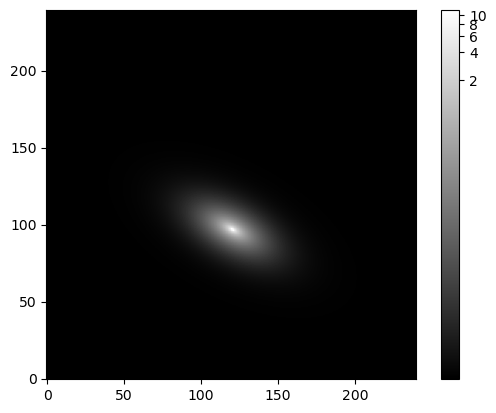

In [91]:
ny, nx = 240, 240  # image size

y, x = np.mgrid[0:ny, 0:nx]

sersic_model = models.Sersic2D(
    amplitude=1, r_eff=5, n=2.5, x_0=120.5, y_0=96.5,
    ellip=0.5, theta=-0.5)

image = sersic_model(x, y)

plt.imshow(image, cmap='gray', origin='lower', norm=simple_norm(image, stretch='log', log_a=10000))
plt.colorbar()

制作psf
* 还原一个真实观测到的图像，需要卷积一个PSF
* PSF取决于仪器和大气条件，这里假设一个简单的2D高斯分布

PSF image size: (41, 41)


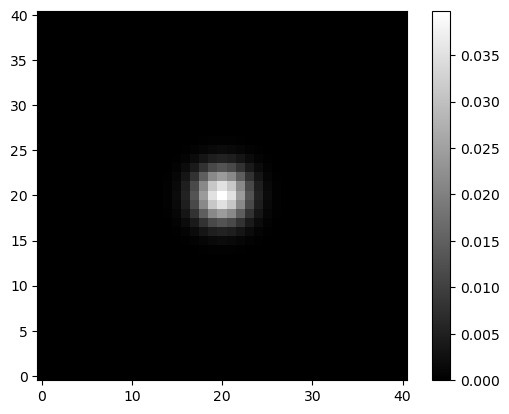

In [92]:
size = 20  # PSF size (PSF image size = 2*size + 1)

sigma_psf = 2.0
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)  # 对psf归一化
plt.imshow(psf, origin='lower', cmap='gray')
plt.colorbar()
print("PSF image size: {}".format(psf.shape))

将图像和psf卷积

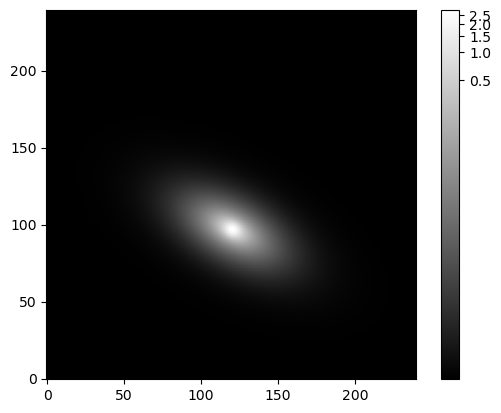

In [93]:
image = convolve(image, psf)
plt.imshow(image, cmap='gray', origin='lower', norm=simple_norm(image, stretch='log', log_a=10000))
plt.colorbar()

添加噪声

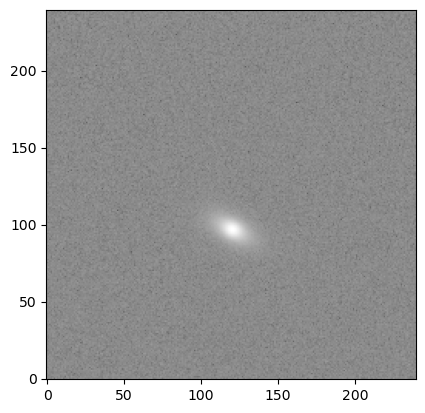

In [94]:
np.random.seed(1)
snp = 100.0
image += (1.0 / snp) * np.random.standard_normal(size=(ny, nx))
plt.imshow(image, cmap='gray', origin='lower', norm=simple_norm(image, stretch='log', log_a=10000))

In [95]:
image.shape

(240, 240)

## 数据准备
除了图像本身之外，statmorph还需要输入：  
1. weight map: 与sci_img的尺寸相同，representing one standard deviation at each pixel value；如果没有，可通过Gain生成
2. Gain: `Gain * sci_img = electrons/pixel`; statmorph内部可通过Gain生成weight map
3. segmentation map: a map to label the pixels belonging to different sources

设置Gain

In [96]:
gain = 10000.0

输入segmentation map

In [97]:
threshold = photutils.detect_threshold(image, 1.5)
npixels = 5  # minimum number of connected pixels
segm = photutils.detect_sources(image, threshold, npixels)
segm

<photutils.segmentation.core.SegmentationImage>
shape: (240, 240)
nlabels: 24
labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]

检测到的面积最大的源的label: 11


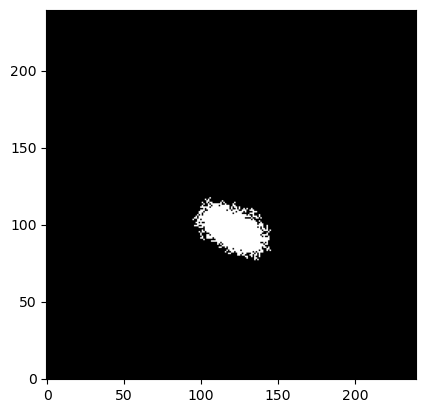

In [98]:
label = np.argmax(segm.areas) + 1  # 找到目标源在segm里的label
print("检测到的面积最大的源的label: {}".format(label))
segmap = (segm.data == label)  # 得到目标源的segmetation map

plt.imshow(segmap, origin='lower', cmap='gray')

使用滤波器去掉图像边缘的毛刺
* 这一步不做会怎样？

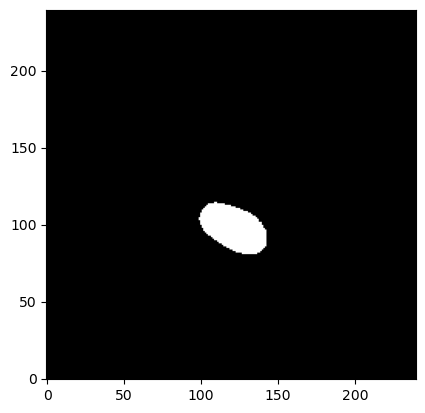

In [99]:
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.5
plt.imshow(segmap, origin='lower', cmap='gray')

In [100]:
segmap = segmap + 0  # 将segmap中的True/False换成1/0

# Running statmorph

对单个源跑statmorph

In [101]:
obj_morphs = statmorph.SourceMorphology(
    image=image, 
    segmap=segmap, 
    label=1, # 必须指定目标源在segmap中的label
    gain=gain,  # 没有weight map的话，输入gain自动生成
    psf=psf  # 已测试，没有psf会显著影响结果
)
print("sersic index: {}".format(obj_morphs.sersic_n))

sersic index: 2.5177196842408684


对多个源跑statmorph

In [102]:
source_morphs = statmorph.source_morphology(
    image=image, 
    segmap=segmap,  # 
    gain=gain, 
    psf=psf
    )
print("sersic index: {}".format(source_morphs[0].sersic_n))

sersic index: 2.5177196842408684


## 获取目标源的拟合结果
* 各个输出参数的定义：https://statmorph.readthedocs.io/en/latest/api.html
* 每个参数的后缀: '_centroid'表示面心；'_asymmetry'表示最小化不对称后的

In [103]:
morph = source_morphs[0]  # 调出第0号源，对应segment中label=1的源的拟合结果

位置信息

In [112]:
# 中心坐标
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)

# postage stamp是指目标源在图像上的box
print('postage stamp x方向的像素数 =', morph.nx_stamp)
print('postage stamp y方向的像素数 =', morph.ny_stamp)

print('postage stamp的xmin =', morph.xmin_stamp)
print('postage stamp的xmax =', morph.xmax_stamp)
print('postage stamp的ymin =', morph.ymin_stamp)
print('postage stamp的ymax =', morph.ymax_stamp)

xc_centroid = 120.56456719256916
yc_centroid = 96.57155410350443
xc_asymmetry = 120.50540444782861
yc_asymmetry = 96.50568885743442
postage stamp x方向的像素数 = 66
postage stamp y方向的像素数 = 66
postage stamp的xmin = 88
postage stamp的xmax = 153
postage stamp的ymin = 65
postage stamp的ymax = 130


椭圆信息

In [105]:
print('ellipticity_centroid (椭率) =', morph.ellipticity_centroid)
print('elongation_centroid (a/b) =', morph.elongation_centroid)
print('orientation_centroid (PA, 跟photutils的定义一致) =', np.rad2deg(morph.orientation_centroid))

print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', np.rad2deg(morph.orientation_asymmetry))

ellipticity_centroid (椭率) = 0.42523825381204616
elongation_centroid (a/b) = 1.7398513499417694
orientation_centroid (PA, 跟photutils的定义一致) = -28.780575643485918
ellipticity_asymmetry = 0.42507827242021723
elongation_asymmetry = 1.7393672077930442
orientation_asymmetry = -28.77683016182569


半径相关

In [106]:
print('rpetro_circ (Petrosian半径) =', morph.rpetro_circ)
print('rpetro_ellip (椭圆的Petrosian半径) =', morph.rpetro_ellip)

print('rhalf_circ (圆孔径的半光半径) =', morph.rhalf_circ)
print('rhalf_ellip (椭圆孔径的半光半径) =', morph.rhalf_ellip)

print('rmax_circ (圆孔径的半径) =', morph.rmax_circ)
print('rmax_ellip (椭圆孔径的半径) =', morph.rmax_ellip)

print('r20 =', morph.r20)
print('r50 =', morph.r50)
print('r80 =', morph.r80)

rpetro_circ (Petrosian半径) = 9.613637842179184
rpetro_ellip (椭圆的Petrosian半径) = 12.727153702161258
rhalf_circ (圆孔径的半光半径) = 4.714640532907066
rhalf_ellip (椭圆孔径的半光半径) = 6.148515364419844
rmax_circ (圆孔径的半径) = 27.611791491839295
rmax_ellip (椭圆孔径的半径) = 29.92048697550033
r20 = 2.2569403345441597
r50 = 4.306399885814649
r80 = 7.800600999600807


非形态学参数

In [107]:
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)

Gini = 0.4992760092391857
M20 = -1.7479160286463131
F(G, M20) = -0.2772779464141357
S(G, M20) = -0.07567707883504377
C = 2.6930399314698112
A = 0.004119671158522368
S = 0.08130003088309246


其他

In [109]:


print('sn_per_pixel =', morph.sn_per_pixel)
print('sersic_amplitude =', morph.sersic_amplitude)
print('sersic_rhalf =', morph.sersic_rhalf)
print('sersic_n =', morph.sersic_n)
print('sersic_xc =', morph.sersic_xc)
print('sersic_yc =', morph.sersic_yc)
print('sersic_ellip =', morph.sersic_ellip)
print('sersic_theta =', morph.sersic_theta)
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)

sn_per_pixel = 43.734056199586796
sersic_amplitude = 0.9940346425550363
sersic_rhalf = 5.012933403721286
sersic_n = 2.5177196842408684
sersic_xc = 120.50629991802779
sersic_yc = 96.50124608777263
sersic_ellip = 0.5008089470717993
sersic_theta = 2.6407424496592307
sky_mean = -0.00018649894899029103
sky_median = 5.2310976021624645e-05
sky_sigma = 0.010006545422104123
flag = 0
flag_sersic = 0


Examining the fitted Sersic profile

Text(0.5, 1.0, 'Residual')

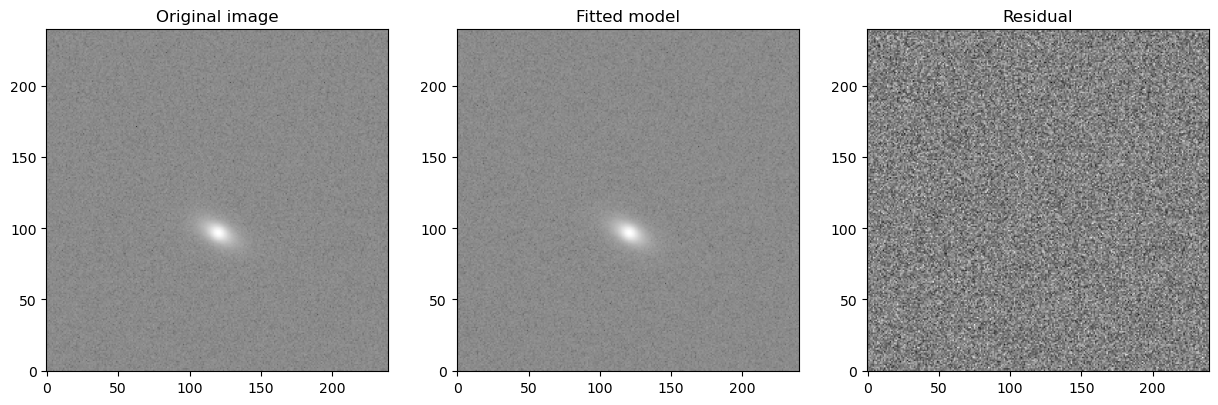

In [110]:
ny, nx = image.shape
y, x = np.mgrid[0:ny, 0:nx]
fitted_model = statmorph.ConvolvedSersic2D(
    amplitude=morph.sersic_amplitude,
    r_eff=morph.sersic_rhalf,
    n=morph.sersic_n,
    x_0=morph.sersic_xc,
    y_0=morph.sersic_yc,
    ellip=morph.sersic_ellip,
    theta=morph.sersic_theta)
fitted_model.set_psf(psf)  # required when using ConvolvedSersic2D
image_model = fitted_model(x, y)
bg_noise = (1.0 / snp) * np.random.standard_normal(size=(ny, nx))
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.imshow(image, cmap='gray', origin='lower',
           norm=simple_norm(image, stretch='log', log_a=10000))
ax.set_title('Original image')
ax = fig.add_subplot(132)
ax.imshow(image_model + bg_noise, cmap='gray', origin='lower',
           norm=simple_norm(image, stretch='log', log_a=10000))
ax.set_title('Fitted model')
ax = fig.add_subplot(133)
residual = image - image_model
ax.imshow(residual, cmap='gray', origin='lower',
           norm=simple_norm(residual, stretch='linear'))
ax.set_title('Residual')

Examining other morphological diagnostics

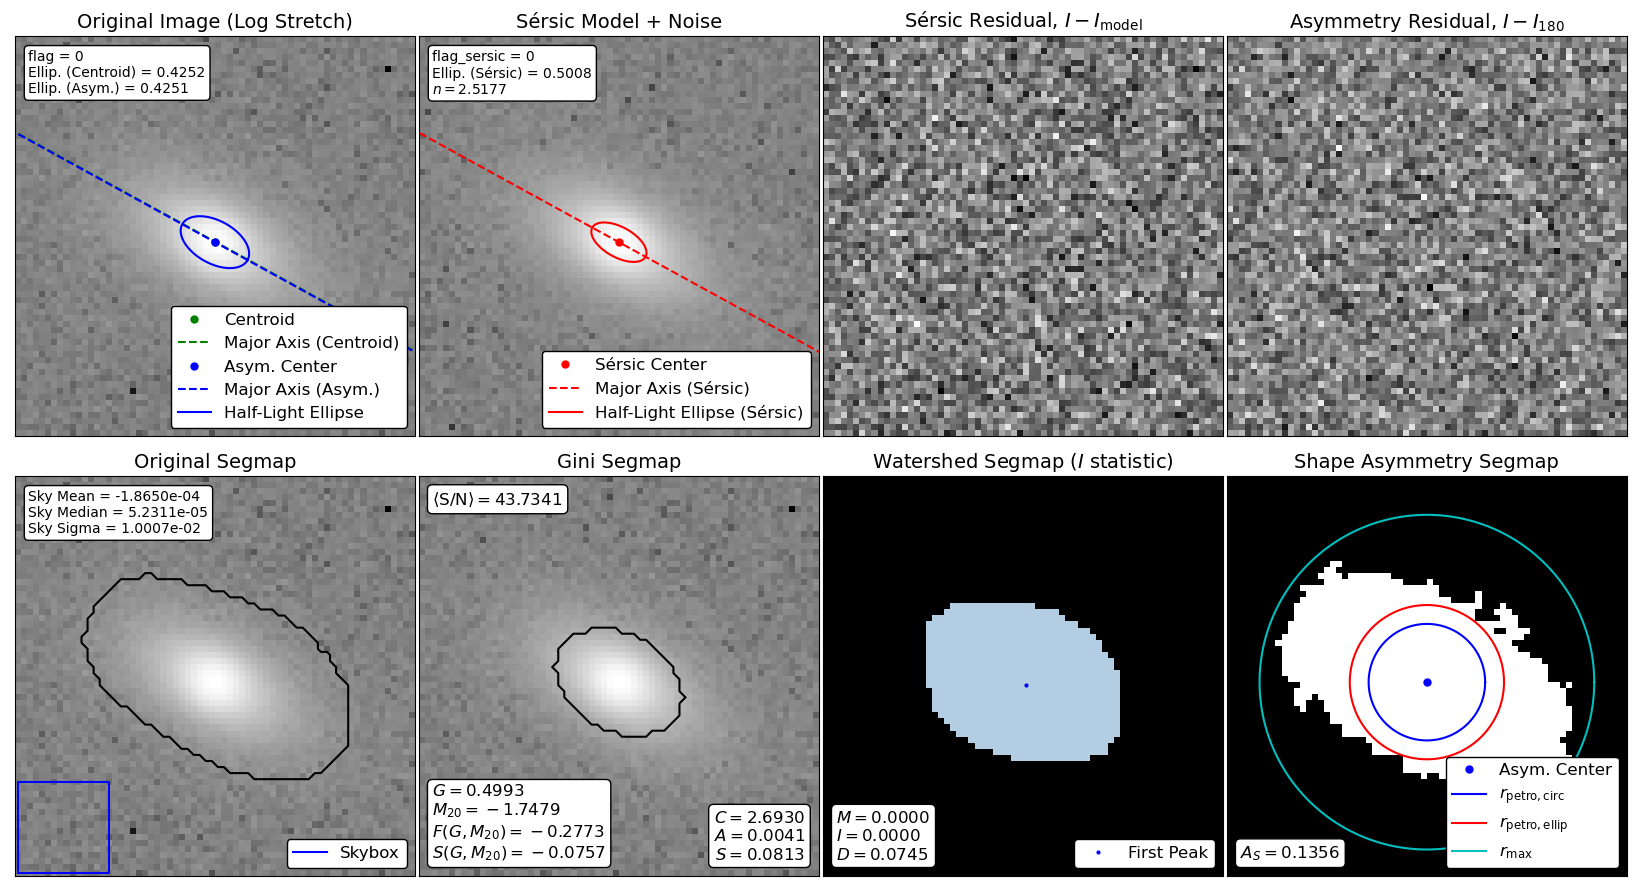

In [111]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)